# Generating synthetic customer data

In this notebook, we will generate synthetic customer data using an LLM. For this we use JSON format. Eventually we will plot the data to see shortcomings of using LLMs for this.

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openai
from tqdm import tqdm

## Define the synthetic data generation function

We'll create a function that uses the LLM to generate customer data in JSON format.

In [2]:
def prompt_ollama(message:str, model="llama3.2"):
    """A prompt helper function that sends a message to ollama and returns only the text response."""
    if isinstance(message, str):
        message = [{"role": "user", "content": message}]
        
    # setup connection to the LLM
    import openai
    client = openai.OpenAI()
    client.base_url = "http://localhost:11434/v1"
    client.api_key = "none"
    response = client.chat.completions.create(
        model=model,
        messages=message
    )
    
    # extract answer
    return response.choices[0].message.content



def prompt(message: str) -> str:
    prompt_text = """Generate one realistic customer profile in valid JSON format with the following structure:
    {
        'name': str,
        'gender': str,
        'age': int,
        'income': float,
        'household_size': int,
        'grocery_list': [
            {'item': str, 'price': float},
            ...
        ]
    }
    Include 5-10 grocery items with realistic prices.
    
    Respond with the JSON data only and no markdown fences."""
    return prompt_ollama(prompt_text)

# Test the function
sample_data = prompt("Generate a customer profile")
print(sample_data)

{"name": "John Doe", "gender": "male", "age": 42, "income": 120000.0, "household_size": 3, "grocery_list": [{"item": "Eggs", "price": 1.99}, {"item": "Milk", "price": 2.49}, {"item": "Bread Loaf", "price": 2.99}, {"item": "Chicken Breast", "price": 6.99}, {"item": "Rice (20 lbs)", "price": 29.99}, {"item": "Ground Beef (80/20%)", "price": 7.99}, {"item": "Granola Bars", "price": 4.49}, {"item": "Yogurt Small Cup", "price": 1.39}, {"item": "Apple Brown Sugar Muffins (6 pack)", "price": 8.49}, {"item": "Bottled Water (24 pk)", "price": 12.99}]}


## Collect and validate customer records

We'll generate 10 customer records and validate the JSON format.

In [3]:
customer_records = []

for i in tqdm(range(100)):
    try:
        data = prompt("Generate a customer profile")
        # Validate JSON
        customer_data = json.loads(data)
        customer_records.append(customer_data)
    except json.JSONDecodeError:
        print(f"Invalid JSON format in record {i+1}")

print(f"\nCollected {len(customer_records)} valid customer records")

 12%|████████▏                                                           | 12/100 [03:54<29:51, 20.36s/it]

Invalid JSON format in record 12


 20%|█████████████▌                                                      | 20/100 [06:34<27:50, 20.88s/it]

Invalid JSON format in record 20


 21%|██████████████▎                                                     | 21/100 [06:56<27:47, 21.11s/it]

Invalid JSON format in record 21


 23%|███████████████▋                                                    | 23/100 [07:31<23:50, 18.58s/it]

Invalid JSON format in record 23


 50%|██████████████████████████████████                                  | 50/100 [10:25<05:30,  6.60s/it]

Invalid JSON format in record 50


 62%|██████████████████████████████████████████▏                         | 62/100 [12:04<07:54, 12.48s/it]

Invalid JSON format in record 62


 78%|█████████████████████████████████████████████████████               | 78/100 [17:46<07:21, 20.05s/it]

Invalid JSON format in record 78


 83%|████████████████████████████████████████████████████████▍           | 83/100 [19:18<05:40, 20.03s/it]

Invalid JSON format in record 83


 84%|█████████████████████████████████████████████████████████           | 84/100 [19:39<05:21, 20.11s/it]

Invalid JSON format in record 84


 86%|██████████████████████████████████████████████████████████▍         | 86/100 [20:03<03:36, 15.46s/it]

Invalid JSON format in record 86


100%|███████████████████████████████████████████████████████████████████| 100/100 [23:39<00:00, 14.20s/it]


Collected 90 valid customer records


## Transform data into a DataFrame

We'll create two DataFrames:
1. Customer information
2. Calculate total weekly grocery spending

In [4]:
# Extract customer info
customer_info = []
for record in customer_records:
    try:
        # Calculate total spending
        total_spending = sum(item['price'] for item in record['grocery_list'])
        
        customer_info.append({
            'name': record['name'],
            'gender': record['gender'],
            'age': record['age'],
            'income': record['income'],
            'household_size': record['household_size'],
            'weekly_spending': total_spending
        })
    except:
        print("Error processing record")

df = pd.DataFrame(customer_info)
display(df)

Error processing record
Error processing record
Error processing record


,name,gender,age,income,household_size,weekly_spending
0,Emily Chen,Female,32,85000.0,3.0,19.95
1,John Doe,male,42,50000.0,2.0,34.95
2,John Doe,male,42,110000.0,2.0,41.48
3,John Doe,male,32,60000.0,3.0,22.78
4,Emily Johnson,Female,32,120000.0,2.0,28.99
...,...,...,...,...,...,...
82,Emily Chen,Female,32,80000.0,3.0,35.90
83,John Doe,male,32,80000.0,3.0,25.50
84,John Doe,male,35,60000.0,2.0,33.86
85,Emily Chen,female,42,120000.0,4.0,46.00


## Visualize relationships in the data

Let's create several plots to analyze relationships between variables:

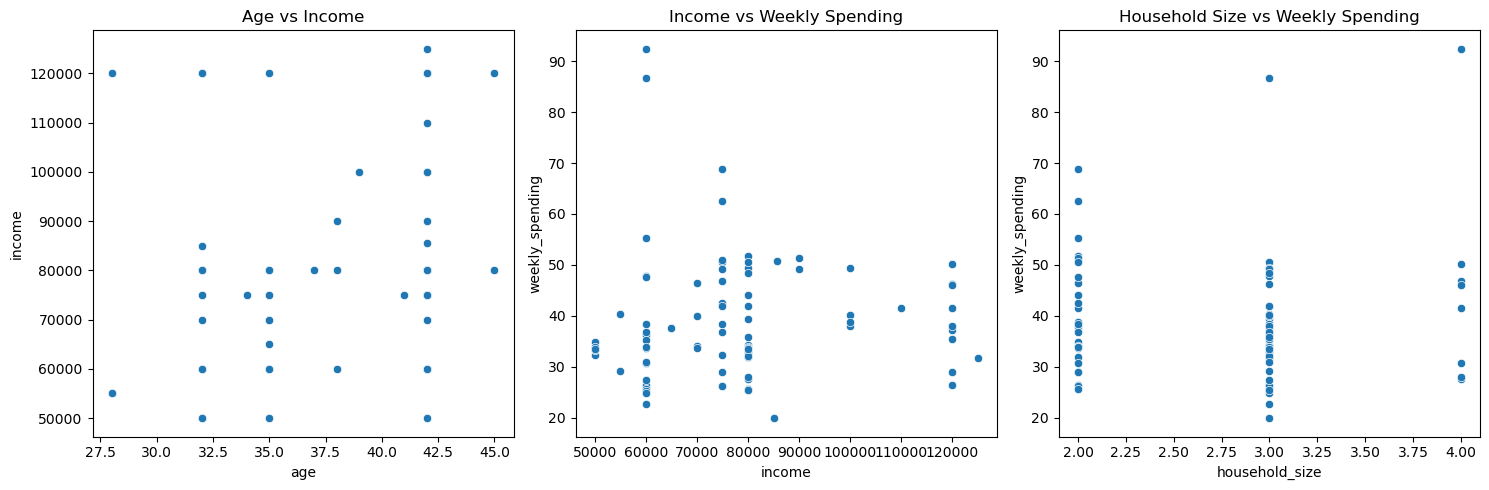

In [5]:
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Age vs Income
sns.scatterplot(data=df, x='age', y='income', ax=ax1)
ax1.set_title('Age vs Income')

# Income vs Weekly Shopping
sns.scatterplot(data=df, x='income', y='weekly_spending', ax=ax2)
ax2.set_title('Income vs Weekly Spending')

# Household Size vs Weekly Shopping
sns.scatterplot(data=df, x='household_size', y='weekly_spending', ax=ax3)
ax3.set_title('Household Size vs Weekly Spending')

plt.tight_layout()
plt.show()

## Additional Analysis: Shopping patterns by gender

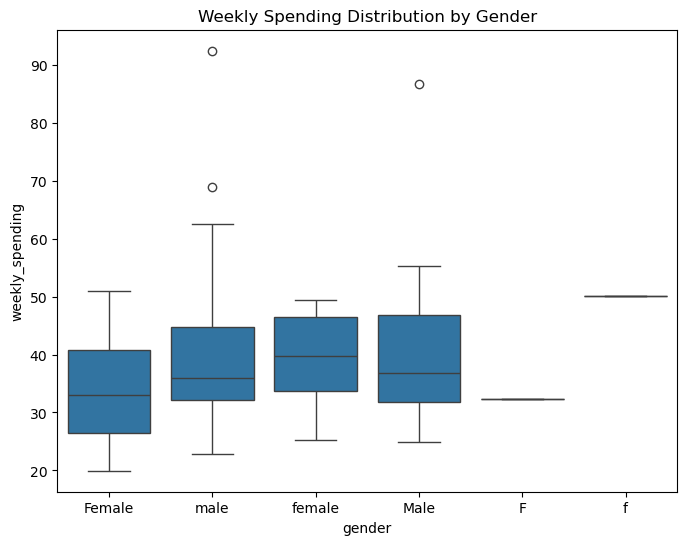

In [6]:
# Box plot of weekly spending by gender
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='gender', y='weekly_spending')
plt.title('Weekly Spending Distribution by Gender')
plt.show()

## Exercise
Modify the prompt to prevent multiple forms of "Male", "male" or "m" genders.